In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import datashader as ds
import xarray as xr
from datashader import transfer_functions as tf, reductions as rd


In [16]:
#1. Define the boundary conditions
# Needed: surface temperature forcing (sin wave at the surce), temperature profile (intinal conditions), bottom boundary
# condition, time step, grid size, thermal conductivity, n (number of vertical grid cells)

# Define set up of the parameters of the model
n = 30 # number of vertical grids (includes top and bottom)
n_coeffs = n-2 # number of coefficients for the tridiag solver
dz = 0.05 # vertical grid spacing (in meters)
dt = 3600 # time step in seconds
depth = dz * n # the depth of the soil modeled
kap = 8e-7 # soil diffusivity (m2 s-1)
la = (dt*kap)/(dz**2) # la as defined with dt*kappa/dz^2 (unitless) 
time_steps = 200 # number of time steps to calculate
T_bar = 20. # Average temperature of bottom layer
A = 10. # Amplitude of sine wave for surface layer

print(f"la: {la}") 
print(f"dt/(dz^2): {dt / (dz**2)}")

la: 1.1519999999999997
dt/(dz^2): 1439999.9999999998


In [17]:
## Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
# 
def TDMAsolver(coeffs):
    """
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    """

    a = coeffs[1:, 0]
    b = coeffs[:, 1]
    c = coeffs[:-1, 2]
    d = coeffs[:, 3]

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]

    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [18]:
## Define boundary conditions

# Initialize temperature, time, and depth arrays
Temps = np.full((n, time_steps), np.nan)
tao = np.array([t*dt for t in np.arange(time_steps)])
depths = np.array([-d*dz for d in np.arange(n)])

def temp_surface(tao, T_bar, A):
    """
    Calculate surface temperature for a set of times (tao)
    """
    
    omega = (2*np.pi) / (86400)
    T = T_bar + A * np.sin(omega * tao) #  + np.pi/2 for time offset
    
    return T

# Initialize boundary conditions in Temps array
Temps[0,:] = temp_surface(tao, T_bar, A) # Surface temperature
Temps[-1, :] = T_bar # Temperature at lower boundary
Temps[:, 0] = T_bar # Temperature at tau=0

# Some initial tries of tao=0 boundary coundition

# Linear
# Temps[:, 0] =  np.linspace(T_bar+10, T_bar, n) # Lowest depth = T_bar

# Diverging from tmax in center
# gauss = signal.gaussian(n, std=3)
# Temps[:,0] = gauss

In [19]:
#Coefficient matrix for tridiagonal solver
coeffs = np.full((n_coeffs, 4), 0.)

# 2. Finding the coefficents for a, b, c, d
for i, t in enumerate(tao[1:-1]):
    
    # Index in temperature array
    Temp_idx = i+1

    # depth = 1
    coeffs[0, 1] = 1 + 2 * la
    coeffs[0, 2] = - la
    coeffs[0, 3] = Temps[1,Temp_idx-1] + la * Temps[0, Temp_idx]

    # depth = bottom
    coeffs[-1, 0] = -la
    coeffs[-1, 1] = 1 + 2 * la
    coeffs[-1, 3] = Temps[-2, Temp_idx-1] + la * Temps[-1, Temp_idx]

    # Loop through 
    for depth in np.arange(coeffs.shape[0])[1:-1]:
        coeffs[depth, 0] = -la
        coeffs[depth, 1] = 1 + 2 * la
        coeffs[depth, 2] = -la
        coeffs[depth, 3] = Temps[depth, Temp_idx-1]

    Temps[1:-1,Temp_idx] = TDMAsolver(coeffs)


In [ ]:
## Sample output plot
# NOTE: does not work for large (e.g. 1 billion) points, need to use
# a different plotting package like datashader
fig, ax = plt.subplots(**{'figsize':(10,5)})

# Create grid to plot on
x, y = np.meshgrid(tao, depths)

# Plot temperatures
temp_plt = ax.pcolormesh(x, y, Temps)
# temp_plt = ax.contourf(x, y, Temps) #Contour plot

ax.set_xlabel('Time [s]')
ax.set_ylabel('Depth [m]')

fig.colorbar(temp_plt)

plt.show()


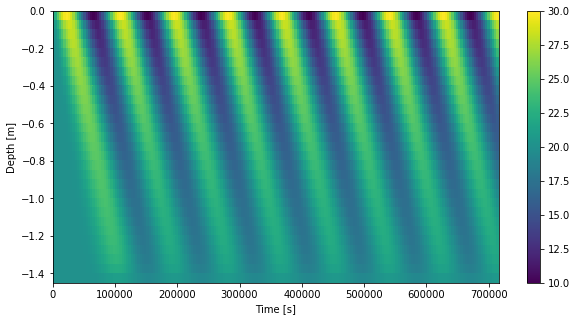

In [20]:
#x, y = np.meshgrid(tao, depths)
da = xr.DataArray(Temps, coords=[('depth',depths), ('tau',tao)])
da.to_netcdf('8_day_1500_depth_test.nc')

In [9]:
#x, y = np.meshgrid(tao, depths)
da = xr.DataArray(Temps, coords=[('depth',depths), ('tau',tao)])
da.to_netcdf('8_day_1500_depth_test.nc')

In [14]:
# First try at using the tridiag solver from github
test_coeff = np.array([[0, 2, -.5, 35],
                       [-.5, 2, -.5, 20],
                       [-.5, 2, 0, 30]])

v = TDMAsolver(test_coeff)
print(test_coeff,v)

# Linear algebra solution
v_linalg = np.linalg.solve(test_coeff[:,:-1], test_coeff[:, -1])
print(v_linalg)

[[ 0.   2.  -0.5 35. ]
 [-0.5  2.  -0.5 20. ]
 [-0.5  2.   0.  30. ]] [22.67857143 20.71428571 20.17857143]
[35. 20. 30.]
[30.  22.5 20. ]


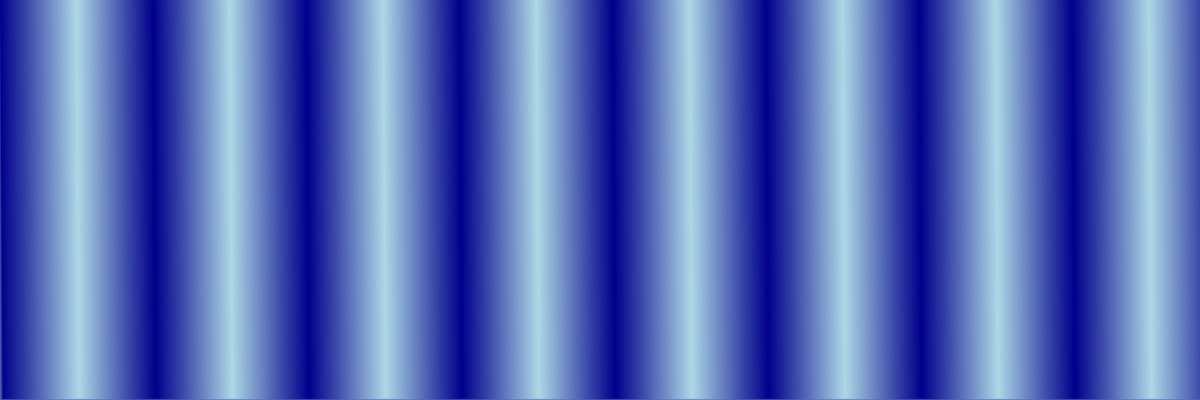

In [8]:
tf.shade(ds.Canvas(plot_height=400, plot_width=1200).raster(test_data['__xarray_dataarray_variable__']))